In [1]:
import sys, os
sys.path.insert(1, os.path.join(os.getcwd(), "src"))
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from my_library import read_log, filter_results
from pprint import pprint

%matplotlib inline

In [2]:
TEST_RESULTS_DIR = "log_files"

results_dir = os.path.join(os.getcwd(), TEST_RESULTS_DIR)
files = os.listdir(results_dir)
files = [f for f in files if "_avg" in f] # average files only
files.sort()


# !ls -1 {results_dir}
# print()
# pprint(files)

In [3]:
# FILTER RESULT FILES

# ALL
selected_files = files
# FIILTER IF CONTAINS STRINGS
select_str = ["mnist", "lr-warmup"]
# select_str = ["test", "C"]
for s in select_str:
    selected_files = [f for f in selected_files if s in f]

# LOAD RESULTS FROM SELECTED FILES
selected_files = [os.path.join(results_dir,f) for f in selected_files]
data = []
for f in selected_files:
    data.append(read_log(f))

print(f"Loaded {len(data)} result files.")


metadata = [d["config"] for d in data]
metadata = pd.DataFrame(metadata, columns=metadata[0].keys())
results = [d["results"] for d in data]
results = pd.DataFrame(results, columns=results[0].keys())

Loaded 72 result files.


In [17]:
#####################################
#    DEFINE FILTERS FOR RESULTS
#####################################

filters = {}
filters["dataset_distribution"] = []
filters["client_batch_size"] = [32]
filters["client_n_epochs"] = [1]
filters["mobility_rate"] = [0.0]
filters["server_global_rate"] = []

filters["dataset_name"] = []
filters["model_type"] = []
filters["client_algorithm"] = []

filters["client_lr"] = []
filters["client_selection_fraction"] = []
#####################################
#####################################
selected_metadata, selected_results = filter_results(metadata, results, filters,
                                                     sort_by = ["dataset_distribution","client_batch_size"])
used_filters = [f for f in filters.keys() if filters[f]]
print(f"Selected {len(selected_metadata)} results.")
selected_metadata.head()
# selected_results.head()

Selected 8 results.


,client_algorithm,client_batch_size,client_lr,client_n_epochs,client_selection_fraction,clients_distribution,clients_mobility,dataset_distribution,dataset_name,debug,...,model_init,model_type,n_clients,n_clusters,server_global_rate,stdout_frequency,stdout_verbosity,stop_condition,stop_value,log_file
0,sgd,32,0.01,1,0.3,balanced,False,iid,mnist,False,...,random,mnist,250,25,1,1,2,rounds,250,log_files/mnist_sgd_lr-warmup-0
11,sgd,32,0.01,1,0.3,balanced,False,iid,mnist,False,...,random,mnist,250,25,3,1,2,rounds,250,log_files/mnist_sgd_lr-warmup-1
22,sgd,32,0.01,1,0.3,balanced,False,iid,mnist,False,...,random,mnist,250,25,5,1,2,rounds,250,log_files/mnist_sgd_lr-warmup-2
33,sgd,32,0.01,1,0.3,balanced,False,iid,mnist,False,...,random,mnist,250,25,7,1,2,rounds,250,log_files/mnist_sgd_lr-warmup-3
7,sgd,32,0.01,1,0.3,balanced,False,non_iid,mnist,False,...,random,mnist,250,25,1,1,2,rounds,250,log_files/mnist_sgd_lr-warmup-16


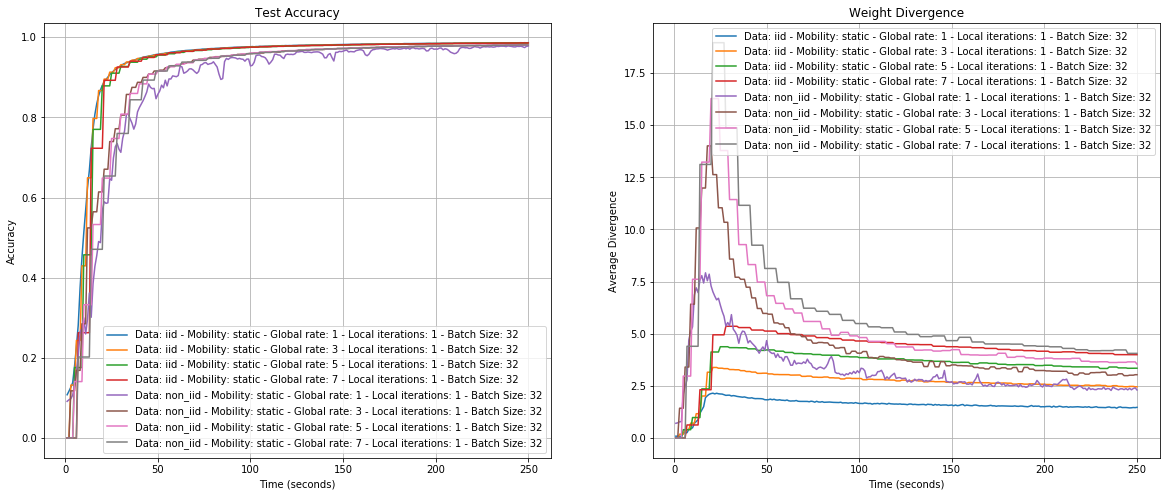

In [18]:
def make_label(config, rule):
    label = ""
    for r in rule: 
        if r == "server_global_rate":
            label += f"Global rate: {config[r]} - "
        elif r == "mobility_rate":
            label += f"Mobility: {config[r] if config['clients_mobility'] else 'static'} - "
        elif r == "client_n_epochs":
            label += f"Local iterations: {config[r]} - "
        elif r == "client_batch_size":
            label += f"Batch Size: {config[r]} - "
        elif r == "dataset_distribution":
            label += f"Data: {config[r]} - "
    # print(label)
    return label[:-3]

# def make_plot_title()

# PLOT RESULTS
plt.figure(figsize=(20,8))
for acc_id, acc_name in enumerate(["test_accuracy","weight_divergence"]):
    plt.subplot(1,2,acc_id+1)
    plt.title("Weight Divergence" if acc_name=="weight_divergence" else "Test Accuracy")
    max_x = 0
    min_x = 1e99
    for r_idx,r in selected_results.iterrows():
        rounds = r["rounds"]
        avg_latency = np.mean(r["latency"])
        avg_latency = r["latency_median"]
        
        X = [round_*avg_latency for round_ in rounds]
        X =rounds
        # X = np.cumsum(r["results"]["latency"])
        acc = r[acc_name]
        label = make_label(selected_metadata.loc[r_idx],
                           rule=["dataset_distribution","mobility_rate", "server_global_rate", "client_n_epochs", "client_batch_size"])

        # plt.plot(X[:100], acc[:100], label=label)
        plt.plot(X, acc, label=label)
        min_x = min(min_x, min(X[-1:]))
        max_x = max(max_x, max(X[-1:]))
    # plt.ylim(0,1)
    # plt.xlim(0,max_x)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Accuracy" if "accuracy" in acc_name else "Average Divergence")
    plt.legend()
    plt.grid()
plt.show()
# print(max_x)
# print(min_x)